100%|██████████| 1370/1370 [00:20<00:00, 65.70it/s]
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


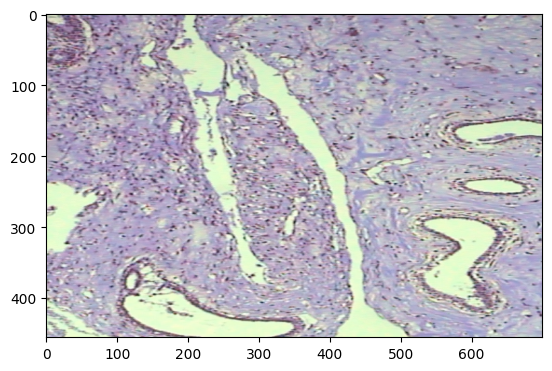

In [1]:
from typing import Any
from torch.utils.data import Dataset
import numpy as np

import cv2
import glob
from tqdm import tqdm 
import pandas as pd 
import os, sys
from PIL import Image

import numpy as np
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add the parent directory to the Python path
sys.path.append(parent_dir)
from tools import BreaKHis
from torchvision import transforms
from PIL import Image
import torch 
import matplotlib.pyplot as plt

myDataset = BreaKHis(root='C:\\Users\\user\\Dersler\\Machine and Deep Learning\\Project\\BreaKHis_v1\\',
                transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]),
                    mf= '40X'
)

img = myDataset[0][0]
img = torch.transpose(img, 0, -1)
plt.imshow(img)

In [14]:
def scale_decimal(image):
    # Perform scaling or normalization to bring the pixel values within the [0, 255] range
    if np.max(image) == 1:
        return image
    
    scaled_image = (image - np.min(image, axis=0)) / (np.max(image, axis=0) - np.min(image, axis=0))  # Scale to [0, 1]
    scaled_image = (scaled_image * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8 data type
    return scaled_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


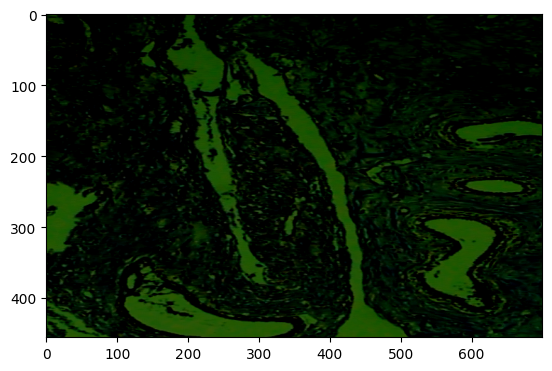

In [2]:
channel_means = np.mean(myDataset.images, axis=(0, 1,2))
scaled = img - channel_means / 255.0
plt.imshow(scaled)

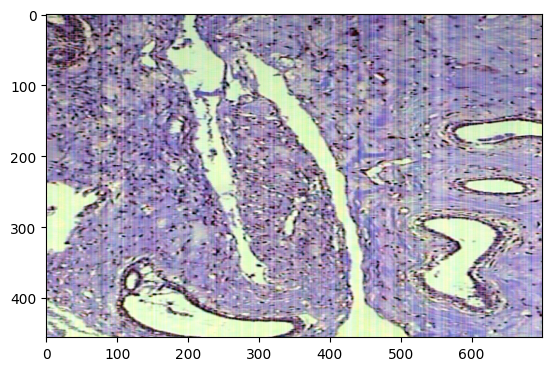

In [24]:
normalized = (img - channel_means / 255).numpy()
plt.imshow(scale_decimal(normalized))

C:\Users\user\AppData\Local\Temp\ipykernel_39700\3856814230.py:6: RuntimeWarning: invalid value encountered in divide
  scaled_image = (image - np.min(image, axis=0)) / (np.max(image, axis=0) - np.min(image, axis=0))  # Scale to [0, 1]


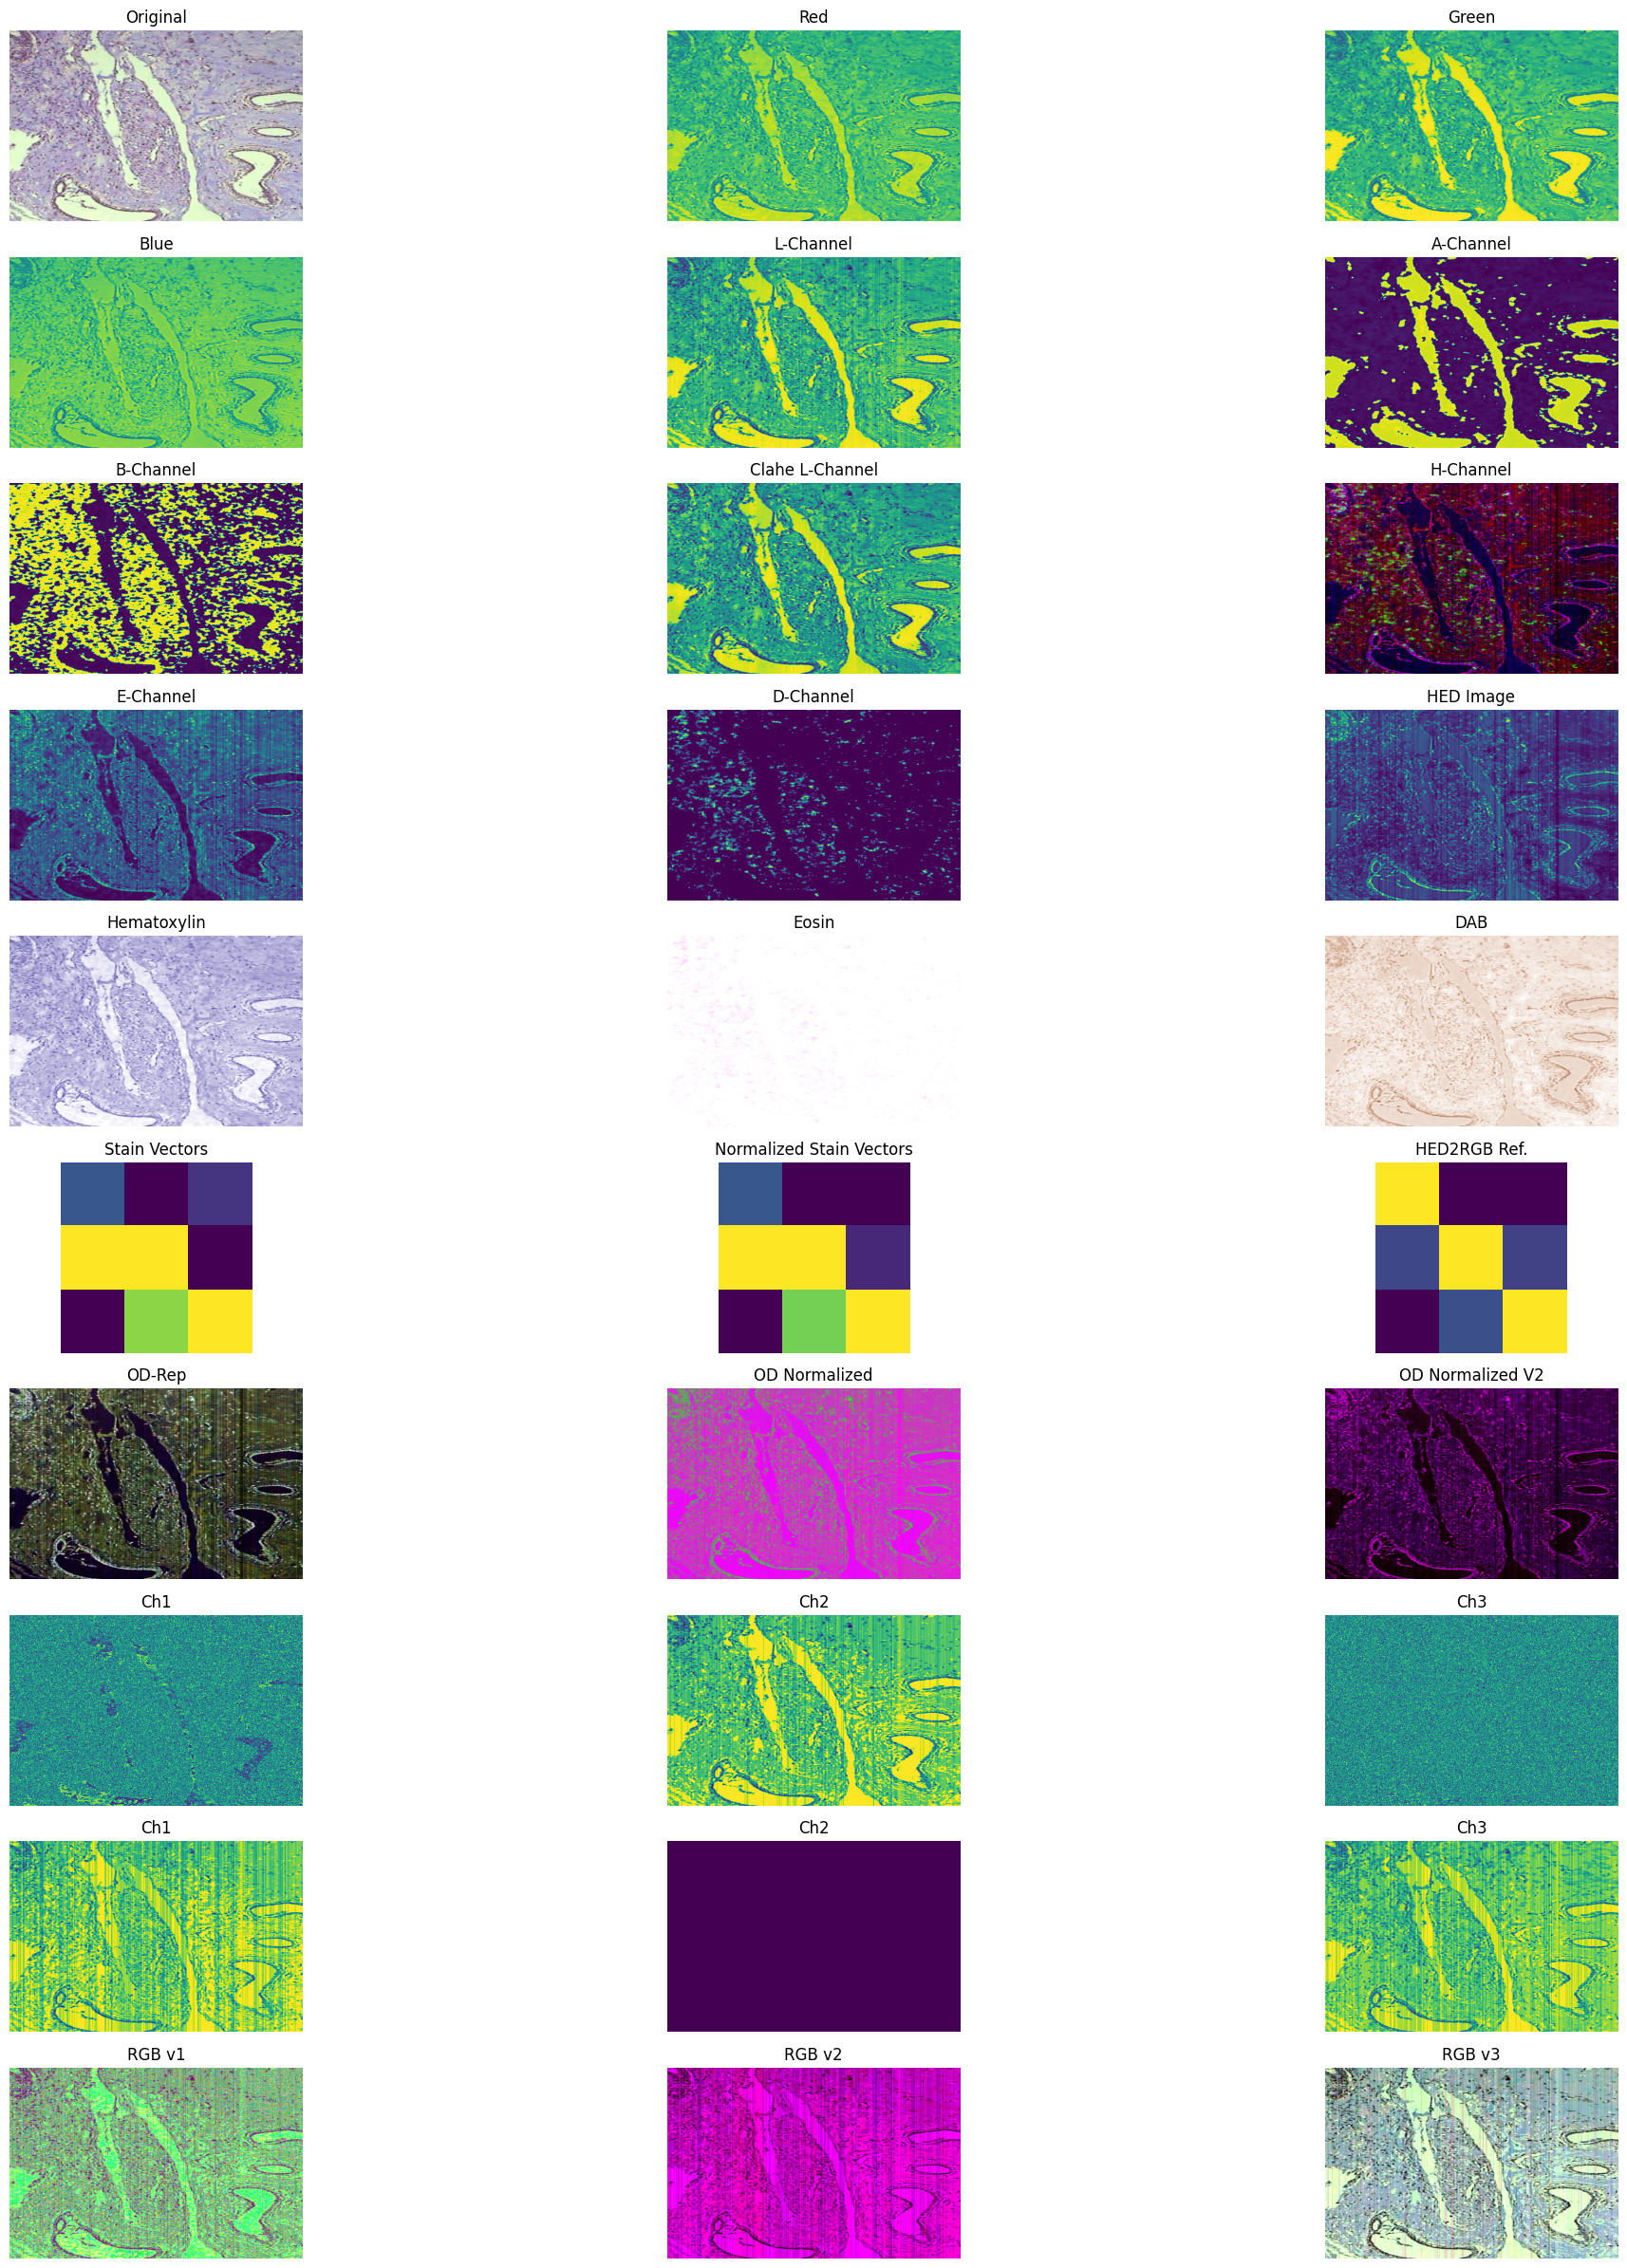

In [252]:
from skimage.color import rgb2hed, hed2rgb
from scipy.linalg import svd, pinv

from skimage.color import separate_stains, combine_stains, hed_from_rgb, rgb_from_hed, hdx_from_rgb, rgb_from_hdx

# Convert the image to Lab color space
# img = img.numpy()
lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# Convert to uint8
lab_image = lab_image.astype(np.uint8)
# Split the Lab image into L, a, and b channels
l_channel, a_channel, b_channel = cv2.split(lab_image)

# Apply CLAHE to the L channel 
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_l_channel = clahe.apply(l_channel)

# Merge the processed L channel with the original a and b channels
clahe_lab_image = cv2.merge((clahe_l_channel, a_channel, b_channel))

# Convert the Lab image back to RGB color space
clahe_rgb_image = cv2.cvtColor(clahe_lab_image, cv2.COLOR_LAB2BGR)

# Separate the stains from the IHC image
hed = rgb2hed(img)

# Create an RGB image for each of the stains
null = np.zeros_like(hed[:, :, 0])
ihc_h = hed2rgb(np.stack((hed[:, :, 0], null, null), axis=-1))
ihc_e = hed2rgb(np.stack((null, hed[:, :, 1], null), axis=-1))
ihc_d = hed2rgb(np.stack((null, null, hed[:, :, 2]), axis=-1))

# Apply negative logarithm to RGB channels
def rgb_to_od(img):
    img = img.astype(np.float32) / 255
    od = -np.log10(img + 1e-8)
    return od

od = rgb_to_od(img)

def get_stain_vectors(od_img):
    od_img = od_img.reshape((-1, 3))
    U, s, V = np.linalg.svd(od_img, full_matrices=False)
    stain_vectors = V[:3]
    return stain_vectors

stain_vectors = get_stain_vectors(od)

def normalize_stain_vectors(stain_vectors, ref_stain_vectors):
    normalized_stain_vectors = np.dot(np.linalg.inv(ref_stain_vectors), stain_vectors)
    return normalized_stain_vectors

normalized_stain_vectors = normalize_stain_vectors(stain_vectors, hed_from_rgb)

def apply_normalized_stain_vectors(od_img, normalized_stain_vectors):
    od_img_normalized = np.dot(od_img.reshape((-1, 3)), normalized_stain_vectors)
    od_img_normalized = od_img_normalized.reshape(od_img.shape)
    return od_img_normalized

od_normalized = apply_normalized_stain_vectors(od, normalized_stain_vectors)

od_normalizedv2 = separate_stains(od, normalized_stain_vectors)

def od_to_rgb(od_img):
    img = np.exp(-od_img) * 255
    img = img.astype(np.uint8)
    return img

img_out = od_to_rgb(od_normalized)
img_outv2 = od_to_rgb(od_normalizedv2)


def od_to_rgb(od_img):
    img = np.exp(-od_img) * 255
    img = img.astype(np.uint8)
    return img

img_out_gch = np.zeros_like(img)
img_out_gch[:, :, 0] = img[:, :, 0]
img_out_gch[:, :, 1] = img_out[:, :, 1]
img_out_gch[:, :, 2] = img[:, :, 2]

fig, axes = plt.subplots(10,3, figsize=(24, 24))
# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Plot the images in each subplot
titles = ['Original', 'Red', 'Green','Blue',
          'L-Channel', 'A-Channel','B-Channel', 'Clahe L-Channel',
          'H-Channel', 'E-Channel', 'D-Channel', 'HED Image',
          'Hematoxylin', 'Eosin', 'DAB',
          'Stain Vectors', 'Normalized Stain Vectors', 'HED2RGB Ref.', 
          'OD-Rep','OD Normalized', 'OD Normalized V2',
          'Ch1', 'Ch2', 'Ch3',
          'Ch1', 'Ch2', 'Ch3',
          'RGB v1', 'RGB v2', 'RGB v3']

outputs = [img, img[:, :, 0], img[:, :, 1], img[:, :, 2], 
           l_channel, a_channel, b_channel, clahe_l_channel,
           hed, hed[:, :, 0], hed[:, :, 1], hed[:, :, 2],
           ihc_h, ihc_e, ihc_d,
           stain_vectors, normalized_stain_vectors, hed_from_rgb, 
           od, od_normalized, od_normalizedv2,
           img_out[:, :, 0], img_out[:, :, 1], img_out[:, :, 2],
           img_outv2[:, :, 0], img_outv2[:, :, 1], img_outv2[:, :, 2],
           img_out, img_outv2, img_out_gch]

for i, ax in enumerate(axes):
    ax.axis('off')
    ax.imshow(scale_decimal(outputs[i]))
    ax.set_title(titles[i])
plt.tight_layout()


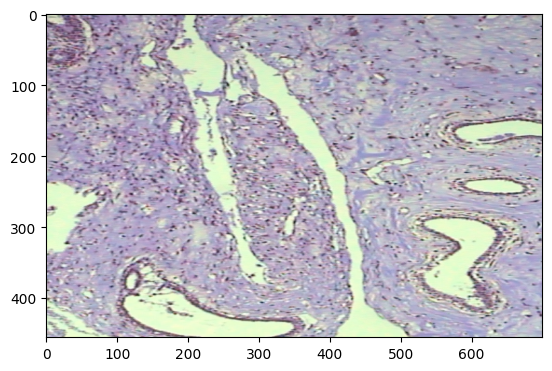

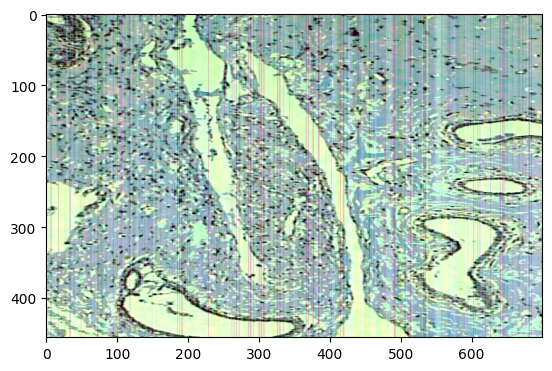

In [256]:
plt.imshow(img)
plt.figure()
plt.imshow(scale_decimal(img_out_gch))


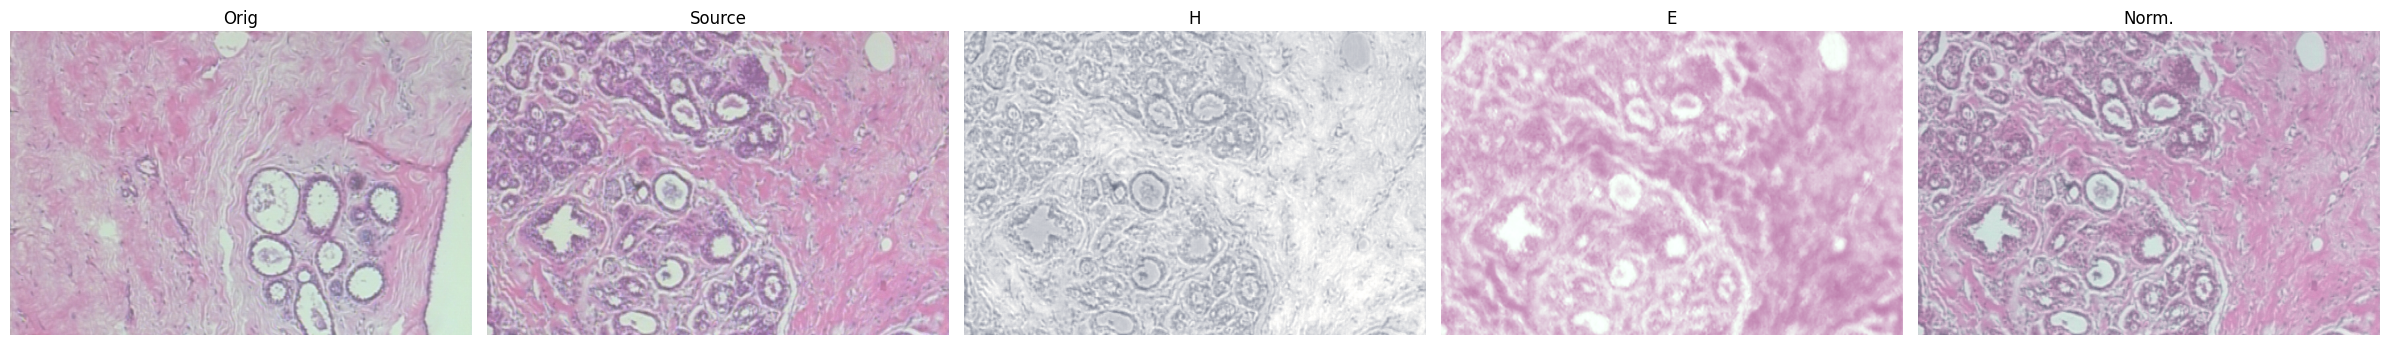

In [209]:
fig, axes = plt.subplots(1,5, figsize=(24, 24))
# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Plot the images in each subplot
titles = [
          'Orig','Source', 'H', 'E', 'Norm.']

outputs = [target, to_transform, H.numpy(), E.numpy(), norm.numpy()]

for i, ax in enumerate(axes):
    ax.axis('off')
    ax.imshow(outputs[i])
    ax.set_title(titles[i])
plt.tight_layout()
